In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import qtensor.states as states 
import qtensor.operators as ops
from qtensor.simulation.finiteTDVP import tdvp, right_mpo_contractions, gs_evolve
import qtensor.simulation.finiteTDVP as sim
import qtensor.thermofield as thf 

Basic state

In [36]:
a = np.random.rand(2,3,3) + 1j * np.random.rand(2,3,3)
b = np.random.rand(2,3,3) + 1j * np.random.rand(2,3,3)

psi = states.mps([a, a, b, a, b])
psi.right_canonical()

H = ops.tilted_ising(N=5)

H_spin_up = ops.tilted_ising(J=0, h=1, g=0, N=5)


Ground state evolve

In [37]:
psi = gs_evolve(psi, H_spin_up, 1000, 100)

Intial energy: (0.3688268833390648-1.8839358890344946e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-4.999999999999678-2.914334599291558e-16j)


Thermofield stuff

In [5]:
N = 8
D = 8
H_usual = ops.tilted_ising(N=N)
beta = 1
H_th = thf.thermofield_hamiltonian(H_usual)


Intial energy: (0.020503272680248055+9.899102491720557e-17j)
Initiating TDVP
TDVP finished!
Final energy: (-7.9999961903288215+6.627345557524767e-16j)
Initiating TDVP
TDVP finished!
Energy at finite temperature: -7.685915299406381


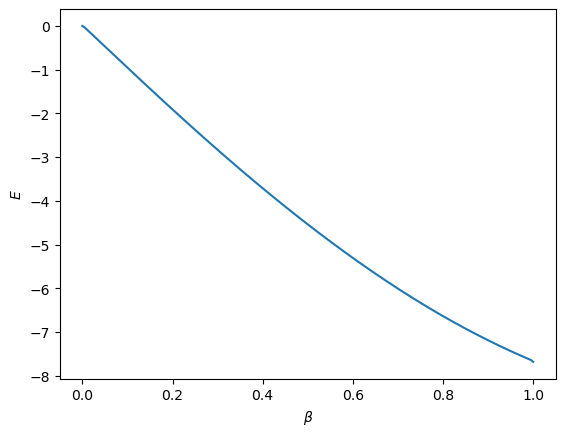

In [6]:
beta_psi, times, energies = thf.finite_T_thermofield(beta, N, D, H_th, steps=200)

In [7]:
# compare this to the groundstate energy
randpsi = states.random_mps(N, 2, D)
gs_evolve(randpsi, H_usual)

Intial energy: (-4.162048062445335-4.426325008087262e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-9.590983998497517+3.469446951953614e-16j)


Testing near thermal ansatz builder

In [2]:
N = 7
D = 6
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)


In [3]:
inf_T_state = sim.inf_T_thermofield_variational(N, D)

Intial energy: (-0.03565230728604184+1.2792230382613336e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-6.999999453191647-2.3656275708559553e-16j)


In [4]:
beta_avg = 0.05
delta_beta = 0.01
beta_profile = beta_avg*np.ones(N) - delta_beta*np.exp(-np.linspace(-N/2, N/2, N)**2) 
# gaussian profile ontop of an average, with temp highest at centre

profile_state = thf.near_thermal(H_tf, beta_profile, D, initial_state=inf_T_state)

Initiating TDVP
TDVP finished!


Initiating TDVP
TDVP finished!
Energy at finite temperature: -0.423076072083636


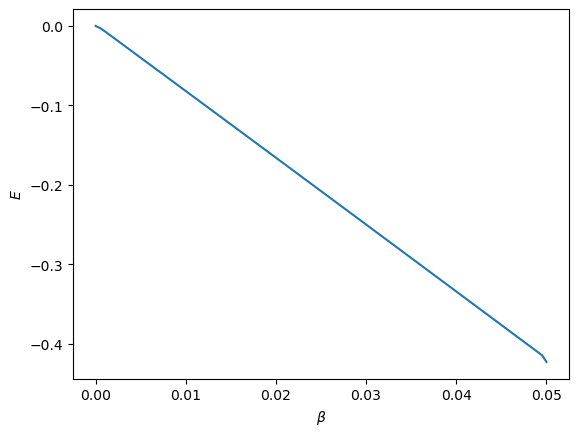

In [5]:
even_state = thf.finite_T_thermofield(beta_avg, N, D, H_tf, initial_state=inf_T_state)[0]

In [6]:
# Checking energy along chain
local_energy = []
even_energy = []
sites = sorted(list(H_usual.sites))
local_ops = ops.extensive_as_terms(H_tf)
for term in local_ops:
    local_energy.append(ops.local_expect(profile_state, term))
    even_energy.append(ops.local_expect(even_state, term))

c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


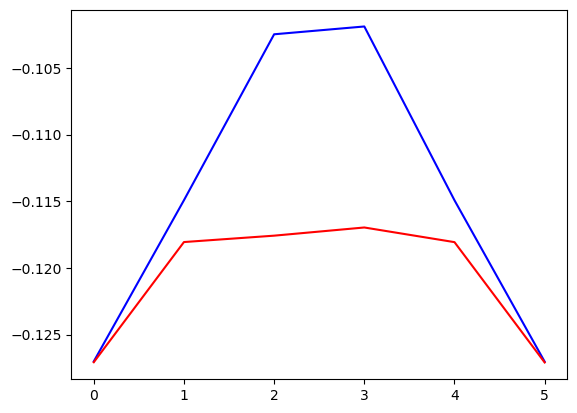

In [7]:
fix, ax = plt.subplots(1,1)
ax.plot(sites[:-1], local_energy, color='b')
ax.plot(sites[:-1], even_energy, color='r')